# **Import Libraries**

In [ ]:
!git clone https://github.com/wcchin/EpiRank.git
%cd EpiRank
!pip install -e .
!pip install datapackage
!pip install tika
!pip install fredapi
!pip install pydotplus

import pandas as pd
import numpy as np
from tqdm import tqdm
import datapackage
import requests
import io
import json
from EpiRank import epirank
from EpiRank import epirank
from math import log
from EpiRank import additional_analysis as aa

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 4000
pd.options.display.max_columns = 4000
pd.set_option('display.max_colwidth', 2000)

In [ ]:
from tika import parser
import re
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import linregress
from scipy import optimize
import numpy as np
import numpy.polynomial.polynomial as npoly
from scipy import optimize
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression, Ridge
from scipy.stats import spearmanr, kendalltau, f_oneway, pearsonr
import statsmodels.regression.mixed_linear_model as sm
import statsmodels.api as sm
from fredapi import Fred
from tqdm import tqdm
from itertools import chain
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from bisect import bisect_right
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from IPython.display import Image, display
from scipy import stats
import pydotplus
import os 
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor


np.random.seed(2017)
%matplotlib inline


def get_datahub_data():

    data_url = 'https://datahub.io/core/covid-19/datapackage.json'
    # to load Data Package into storage
    package = datapackage.Package(data_url)

    # to load only tabular data
    resource = package.resources[5]

    if resource.tabular:
        response = requests.get(resource.descriptor['path'])
        file_object = io.StringIO(response.content.decode('utf-8'))
        case_data = pd.read_csv(file_object)
        
    return case_data

def get_state_code_map():

    file_path = '/kaggle/input/state-code/states_hash.json'

    state_data = pd.read_json(file_path, orient = 'index')
    
    return state_data

def  get_state_square_map():

    file_path = '/kaggle/input/state-square/state_square.json'
    state_square = pd.DataFrame.from_dict(pd.read_json(file_path))
    state_square['State'] = state_square['State'].str.replace('of', 'Of')
    
    return state_square

def get_full_testing_data():
    
    data_url = 'https://covidtracking.com/api/states/daily'

    response = requests.get(data_url)
    file_object = io.StringIO(response.content.decode('utf-8'))
    test_data = pd.read_json(file_object)
    test_data['Province/State'] = test_data['state'].map(state_data.iloc[:,0])
    
    return test_data

def get_icu_bed_capacity_data():

    data_url = 'https://covid19-server.chrismichael.now.sh/api/v1/AggregatedFacilityCapacityCounty'

    response = requests.get(data_url)
    file_object = io.StringIO(response.content.decode('utf-8'))
    beds_data = pd.DataFrame.from_dict(dict(pd.read_json(file_object).iloc[0]).get('data').get('table'))
    
    return beds_data

def state_capital_geo_coordinates():

    file_path = '/kaggle/input/state-capitals/state_capitals.json'

    state_geo_cap = pd.read_json(file_path)

    state_geo_cap_add = [{
        "abbr": "AS",
        "name": "American Samoa",
        "capital": "Pago Pago",
        "lat": "-14.328056",
        "long": "-170.711945"
        },
        {
        "abbr": "DC",
        "name": "District of Columbia",
        "capital": "Washington, D.C.",
        "lat": "38.89511",
        "long": "-77.03637"
        },
        {
        "abbr": "FM",
        "name": "Federated States of Micronesia",
        "capital": "Palikir",
        "lat": "6.92477",
        "long": "158.16109"
        }, 
        {
        "abbr": "PW",
        "name": "Palau",
        "capital": "Melekeok",
        "lat": "7.50043",
        "long": "134.62355"
        },
        {
        "abbr": "MH",
        "name": "Marshall Islands",
        "capital": "Majuro",
        "lat": "7.08971",
        "long": "171.38027"
        }, 
        {
        "abbr": "GU",
        "name": "Guam",
        "capital": "Dededo",
        "lat": "13.51777",
        "long": "144.8391"
        },
        {
        "abbr": "MP",
        "name": "Northern Mariana Islands",
        "capital": "Saipan",
        "lat": "15.21233",
        "long": "145.7545"
        },
        {
        "abbr": "VI",
        "name": "Virgin Islands",
        "capital": "Charlotte Amalie",
        "lat": "18.3419",
        "long": "-64.9307"
        },
        {
        "abbr": "PR",
        "name": "Puerto Rico",
        "capital": "San Juan",
        "lat": "18.466333",
        "long": "-66.105721"
        }]

    state_geo_cap_add = pd.DataFrame.from_dict(state_geo_cap_add)
    state_geo = pd.concat((state_geo_cap, state_geo_cap_add), axis = 0)
    
    return state_geo

def get_weather(case_data, state_geo, start_date='2020-03-07', end_date='2020-04-07', mode = 'read'):
    
    if (mode == 'load'):
        final_weather = pd.DataFrame()
        states = case_data['Province/State'].unique()[:-2]
        for st in tqdm(states):

            lat = state_geo[state_geo['name'] == st]['lat'].unique()
            lng = state_geo[state_geo['name'] == st]['long'].unique()

            stations = list()
            for (lat, lng) in list(zip(lat, lng)):
                try:
                    data_url = 'https://api.meteostat.net/v1/stations/nearby?lat=' + str(lat) + '&lon=' + str(lng) + '&limit=3&key=JNA6UgJF'
                    response = requests.get(data_url)
                    file_object = io.StringIO(response.content.decode('utf-8'))
                    stations += list(pd.DataFrame(json.load(file_object)['data'])['id'].unique())
                except Exception:
                    continue

            station_weather = pd.DataFrame()
            for station_id in list(stations):
                data_url = 'https://api.meteostat.net/v1/history/daily?station=' + str(station_id) + '&start=' + str(start_date) + '&end=' + str(end_date) + '&key=JNA6UgJF'
                response = requests.get(data_url)
                file_object = io.StringIO(response.content.decode('utf-8'))
                if (station_weather.empty):
                    try:
                        station_weather = pd.DataFrame(json.load(file_object)['data'])
                    except Exception:
                        print(station_id)
                        continue
                else:
                      station_weather = pd.concat((station_weather, pd.DataFrame(json.load(file_object)['data'])), axis = 0)


            station_weather = station_weather.set_index('date')
            station_weather = station_weather.astype('float')
            station_weather = station_weather.groupby('date').median()

            if (final_weather.empty):
                final_weather = station_weather
                final_weather['Province/State'] = st
            else:
                station_weather['Province/State'] = st
                final_weather = pd.concat((final_weather, station_weather), axis = 0)
                
        final_weather.to_csv('weather_0703_0704.csv', index = False)
        
    else:
        
        final_weather = pd.read_csv('/kaggle/input/weather/weather_0703_0704.csv')

    return final_weather

def drop_constant_column(dataframe):
    """
    Drops constant value columns of pandas dataframe.
    """
    return dataframe.loc[:, (dataframe != dataframe.iloc[0]).any()]

def get_dp05_census_data():
    dp05 = pd.read_csv('/kaggle/input/dp05-data-with-overlays-v2/ACSDP1Y2018.DP05_data_with_overlays_2020-04-13T234101.csv')
    dp05 = pd.DataFrame(dp05.iloc[1:,:].values, columns = [col.replace('!!','_').replace(' ','_').replace('$','') for col in list(dp05.iloc[:1,:].values[0])])
    dp05_2 = drop_constant_column(dp05.filter(regex='Estimate').replace('N', np.nan)).astype('float')
    dp05_2['Geographic_Area_Name'] = dp05['Geographic_Area_Name']
    return dp05_2

def get_dp03_census_data():

    dp03 = pd.read_csv('/kaggle/input/dp03-data-with-overlays/ACSDP1Y2018.DP03_data_with_overlays_2020-04-08T153457.csv')
    dp03 = pd.DataFrame(dp03.iloc[1:,:].values, columns = [col.replace('!!','_').replace(' ','_').replace('$','') for col in list(dp03.iloc[:1,:].values[0])])

    dp03_2 = drop_constant_column(dp03.filter(regex='Estimate').replace('N', np.nan)).astype('float')
    dp03_2['Geographic_Area_Name'] = dp03['Geographic_Area_Name']
    
    return dp03_2

def get_google_mob_report(date):
    
    states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming']
    mob_val = np.zeros((len(states), 6))
    mob_col = ['Retail_and_Recreation', 'Grocery_and_Pharmacy', 'Parks', 'Transit_Stations', 'Workplaces', 'Residential']
    k = 0

    for st in states:

        raw = parser.from_file("https://www.gstatic.com/covid19/mobility/" + str(date) + "_US_" + st.replace(' ','_') + "_Mobility_Report_en.pdf")
        text = raw['content']
        text = text.replace('\n', '')
        mob_val[k, :] = np.array([int(num.replace('%c','')) for num in re.findall(r'-?\d+%c', text)])
        k += 1

    mob = pd.DataFrame(mob_val, columns = mob_col)
    mob['state'] = states
    mob['state']=mob['state'].str.replace('of','Of')
    return mob

def get_lock_dates():
    
    data_path = '/kaggle/input/us-lockdown-dates-dataset/lockdown_us.csv'

    lock_dates = pd.read_csv(data_path, parse_dates=['Date'])
    lock_dates['Date_Num']=lock_dates['Date'].dt.strftime('%Y%m%d').astype(int)
    lock_dates = pd.to_datetime(lock_dates.groupby('State')['Date_Num'].max(), format='%Y%m%d').reset_index()
    
    return lock_dates

def get_containment_data():
    
    cont_mit_data = pd.read_csv('/kaggle/input/covid19-containment-and-mitigation-measures/COVID 19 Containment measures data.csv', parse_dates = ['Date Start', 'Date end intended'])
    cont_mit_data = cont_mit_data[cont_mit_data['Country'].fillna('').str.contains('US')].sort_values(by='Date Start', ascending = True)
    cont_mit_data['Date_Keywords'] = '{' + cont_mit_data['Date Start'].astype('str') + ' : ' + cont_mit_data['Keywords'] + '}'
    cont_mit_data['Date_Measure'] = '{' + cont_mit_data['Date Start'].astype('str') + ': ' + cont_mit_data['Description of measure implemented'] + '}'
    cont_mit_data = cont_mit_data[['Country','Date_Keywords', 'Date_Measure']].astype('str').groupby('Country').agg(', '.join)
    cont_mit_data = cont_mit_data.reset_index()
    cont_mit_data['state'] = cont_mit_data.reset_index()['Country'].str.replace('US:','').str.strip()
    cont_mit_data['state']= cont_mit_data['state'].str.replace('of','Of')
    
    return cont_mit_data[['state','Date_Keywords', 'Date_Measure']].sort_values(by='state', ascending = True)

def calc_log_cumulative_tests(test_data, state_data):
    test_targ = test_data[(test_data['date']>20200307)].groupby(['state', 'date'])[['positive', 'negative']].sum()

    test_targ['test_rate'] = np.log1p(test_targ['negative']) 
    test_targ['inf_rate'] = np.log1p(test_targ['positive']) 
    test_targ = test_targ.reset_index()
    
    return test_targ


def plot_log_cumulative_tests(test_targ, lock_dates, state_data):
    plotting = test_targ.groupby('state').first()

    for state in plotting.index:
        
        fig = plt.figure(figsize=(20,10))
        ax = fig.add_subplot(221)

        dates = test_targ[(test_targ['state']==state)]['date']
        dates = pd.to_datetime(dates, format = '%Y%m%d')
        levels = test_targ[(test_targ['state']==state)]['inf_rate']

        # Configure x-ticks
        ax.plot(dates, levels, ls='-', marker='o', color='red', label = 'positive')

        group = state

        ax.set_title('Rates ' + state_data.loc[state].iloc[0])

        ax.grid(True)

        dates = test_targ[(test_targ['state']==state)]['date']
        dates = pd.to_datetime(dates, format = '%Y%m%d')
        levels = test_targ[(test_targ['state']==state)]['test_rate']
        # Configure x-ticks
        ax.plot(dates, levels, ls='-', marker='o', color='green', label = 'negative')

        try:
            province_state = state_data.loc[state].iloc[0]
            xposition = [lock_dates[lock_dates['State']==province_state]['Date_Num'].iloc[0]]
            plt.axvline(x=xposition, color='k', linestyle='--')
        except IndexError:
            pass

        group = state

        ax.grid(True)
        ax.legend(loc='best')

        # Format the x-axis for dates (label formatting, rotation)
        fig.autofmt_xdate(rotation=45)
        fig.tight_layout()

    fig.show()
    plt.show()
    
def calculate_growth_rate_slope(test_targ, change_date = 20200329):

    test_targ = test_targ[test_targ['positive']>0]
    test_targ['rank'] = test_targ.groupby('state')['date'].rank()
    new_df3 = pd.DataFrame()
    new_df3['inf_rate_inc'] = test_targ[(test_targ['date']<=change_date)].groupby('state').apply(lambda v: linregress(v['rank'], v['inf_rate'])[0]) * 14
    new_df3['inf_rate_dec'] = test_targ[(test_targ['date']>change_date)].groupby('state').apply(lambda v: linregress(v['rank'], v['inf_rate'])[0]) * 14

    new_df3.reset_index(inplace=True)
    
    return new_df3

def func(breakpoints, x, y, fcache):
    breakpoints = tuple(map(int, sorted(breakpoints)))
    if breakpoints not in fcache:
        total_error = 0
        for f, xi, yi, coefs in find_best_piecewise_polynomial(breakpoints, x, y):
            total_error += ((f(xi) - yi)**2).sum()
        fcache[breakpoints] = total_error
    # print('{} --> {}'.format(breakpoints, fcache[breakpoints]))
    return fcache[breakpoints]

def find_best_piecewise_polynomial(breakpoints, x, y):
    breakpoints = tuple(map(int, sorted(breakpoints)))
    xs = np.split(x, breakpoints)
    ys = np.split(y, breakpoints)
    result = []
    for xi, yi in zip(xs, ys):
        if len(xi) < 2: continue
        coefs = npoly.polyfit(xi, yi, 1)
        f = npoly.Polynomial(coefs)
        result.append([f, xi, yi, coefs])
    return result
    

def plot_log_cumulative_tests_with_change(test_targ, lock_dates, state_data):
    
    st_list = test_targ['state'].unique()
    st_dec = np.zeros((len(st_list)))
    st_inc = np.zeros((len(st_list)))
    k = 0

    for st in tqdm(st_list):

        y = test_targ[test_targ['state']==st][test_targ['positive']>0]['inf_rate'].values
        x = test_targ[test_targ['state']==st][test_targ['positive']>0]['date'].values

        if len(y)<2:
            continue
        
        num_breakpoints = 1
        breakpoints = [optimize.brute(
            func, [slice(1, len(x), 1)]*num_breakpoints, args=(x, y, {}), finish=None)]

        try:
            province_state = state_data.loc[st].iloc[0]
            dt = int(lock_dates[lock_dates['State']==province_state]['Date_Num'].iloc[0].strftime('%Y%m%d'))
            xposition = np.where(x==dt)[0]
            ax.axvline(x=xposition, color='k', linestyle='--')
        except Exception:
            pass

        x = np.arange(0, len(x))

        plt.scatter(x, y, c='blue', s=50, label = 'positive')
        i = 0
        for f, xi, yi, coefs in find_best_piecewise_polynomial(breakpoints, x, y):
            x_interval = np.array([xi.min(), xi.max()])
            print('y = {:35s}, if x in [{}, {}]'.format(str(f), *x_interval))
            if (i == 1):
                label = ''
            else:
                label = 'linear_fit'
            plt.plot(x_interval, f(x_interval), 'ro-', label = label)
            
            if (i == 0):
                st_inc[k] = coefs[1]*14
                prev0 = len(yi)
                prev1 = yi[-1:]
            else:
                st_dec[k] = coefs[1]*14
    
            i+=1

        plt.grid(True)
        plt.legend(loc='best')
        plt.title('Rate change '+ state_data.loc[st].iloc[0])

        k += 1
    
        plt.show()

    new_df = pd.DataFrame(st_dec, columns = ['inf_rate_dec'])   
    new_df['inf_rate_inc'] = st_inc
    new_df['state'] = st_list
    return new_df

def run_variable_selection(growth_rate, mob2, columns, NFOLDS=3, RANDOM_STATE=42, N_REPEATS=30):


    growth_rate['Province/State'] = growth_rate['state'].map(state_data.iloc[:,0])
    new_df3 = pd.merge(growth_rate, mob2, left_on = 'Province/State', right_on = 'state', how='inner')
    cols = list(new_df3.select_dtypes('float').columns)
    cols = ['Retail_and_Recreation', 'Residential',
           'Workplaces', 'inf_rate_dec', 'inf_rate_inc']
    new_df3 = new_df3[new_df3['inf_rate_inc']>0]

    Y = new_df3[cols]['inf_rate_dec'] 
    X = new_df3[cols].drop(['inf_rate_inc', 'inf_rate_dec'], axis = 1)
    X = X.apply(lambda x: x.fillna(x.median()))
    use_cols = list(X.columns)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1, random_state=RANDOM_STATE)
    X_train_enc_sc = scale(X_train)
    X_test_enc_sc = scale(X_test)

    NFOLDS =  NFOLDS
    RANDOM_STATE = RANDOM_STATE
    N_REPEATS = N_REPEATS

    clfs = []
    mae_mod = []
    mae_bas = []
    folds = RepeatedKFold(n_splits=NFOLDS, n_repeats = N_REPEATS, random_state=RANDOM_STATE)
    oof_preds_mod = np.zeros((len(X_train), 1))
    test_preds_mod = np.zeros((len(X_test), 1))
    oof_preds_bas = np.zeros((len(X_train), 1))
    test_preds_bas = np.zeros((len(X_test), 1))
    Y_train = Y_train.reset_index(drop=True)

    for fold_, (trn_, val_) in tqdm(enumerate(folds.split(X_train, Y_train))):
        # print("Current Fold: {}".format(fold_))
        X_trn, Y_trn = X_train.iloc[trn_, :], Y_train[trn_]
        X_val, Y_val = X_train.iloc[val_, :], Y_train[val_]

        X_trn_enc_sc = scale(X_trn)
        X_val_enc_sc = scale(X_val)

        clf = LinearRegression()
        clf.fit(X_trn_enc_sc, Y_trn)
        val_pred = clf.predict(X_val_enc_sc)

        X_test_enc_sc = pd.DataFrame(X_test_enc_sc, columns = use_cols)
        test_fold_pred = clf.predict(X_test_enc_sc)

        mae_mod.append(metrics.mean_absolute_error(Y_val, val_pred))
        mae_bas.append(metrics.mean_absolute_error(Y_val, np.repeat(np.mean(Y_trn), len(val_))))
        oof_preds_mod[val_, :] = val_pred.reshape((-1, 1))
        oof_preds_bas[val_, :] = np.repeat(np.mean(Y_trn), len(val_)).reshape((-1, 1))
        test_preds_mod += test_fold_pred.reshape((-1,1))
        test_preds_bas += np.repeat(np.mean(Y_trn), len(X_test_enc_sc)).reshape((-1, 1))

    test_preds_mod /= NFOLDS * N_REPEATS
    test_preds_bas /= NFOLDS * N_REPEATS
    print('')

    mae_score_cv_mod = np.round(metrics.mean_absolute_error(Y_train, oof_preds_mod.ravel()),4)
    print('')
    print("MAE OOF Model = {}".format(np.round(mae_score_cv_mod, 4)))
    print("MAE CV Model = {}".format(np.round(np.mean(mae_mod), 4)))
    print("MAE STD Model = {}".format(np.round(np.std(mae_mod),4)))

    mae_score_cv_bas = np.round(metrics.mean_absolute_error(Y_train, oof_preds_bas.ravel()),4)
    print('')
    print("MAE OOF Baseline = {}".format(np.round(mae_score_cv_bas, 4)))
    print("MAE CV Baseline = {}".format(np.mean(mae_bas)))
    print("MAE STD Baseline = {}".format(np.round(np.std(mae_bas),4)))

    print('')
    mae_score_test_mod = np.round(metrics.mean_absolute_error(Y_test, test_preds_mod),4)
    print("MAE Test Model = {}".format(mae_score_test_mod))
    mae_score_test_bas = np.round(metrics.mean_absolute_error(Y_test, test_preds_bas),4)
    print("MAE Test Baseline = {}".format(mae_score_test_bas))

    coefficients = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(clf.coef_))], axis = 1)
    coefficients.columns = ['variable', 'weight']
    coefficients['percent'] = np.abs(coefficients['weight'])
    coefficients['percent'] /= coefficients['percent'].sum()
    
    return list(coefficients['variable'].unique()), coefficients

def run_stat_significance(growth_rate, mob4, columns):

    growth_rate['Province/State'] = growth_rate['state'].map(state_data.iloc[:,0])
    mob4['state']=mob4['state'].str.replace('of','Of')
    new_df3 = pd.merge(growth_rate, (mob4.set_index('state')).reset_index(), left_on = 'Province/State', right_on = 'state', how='inner')
    cols = list(new_df3.select_dtypes('float').columns)
    new_df3 = new_df3[new_df3['inf_rate_inc']>0]

    new_df3['targ'] = (new_df3[cols]['inf_rate_dec'] - new_df3[cols]['inf_rate_inc']) / new_df3[cols]['inf_rate_inc']
    Y = new_df3['targ']
    X = new_df3[cols].drop(['inf_rate_inc', 'inf_rate_dec'], axis = 1)
    X = X.apply(lambda x: x.fillna(x.mean()))[columns]
    use_cols = list(X.columns)

    mod = sm.OLS(Y, X)
    res = mod.fit()

    return res, X, Y

def show_correlations(X, Y):
    vars = []
    for col in X.columns:
        if (spearmanr(X[col], Y)[1] < 0.9):
            print(col)
            plt.scatter(X[col], Y)
            plt.ylabel('Growth_rate_decrease')
            plt.xlabel(col)
            vars.append(col)
            print("")
            plt.show()
    print(vars)
    
def show_correlations_color_target_work(X, Y):

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    ax.set_title("Workplaces vs Residential AVG",fontsize=14)
    ax.set_xlabel("Workplaces",fontsize=12)
    ax.set_ylabel("Residential",fontsize=12)
    ax.grid(True,linestyle='-',color='0.75')
    x = X['Workplaces']
    y = X['Residential']
    z = Y

    # scatter with colormap mapping to z value
    ax.scatter(x,y,s=60,c=z, marker = 'o', cmap = cm.jet );

    plt.show()

    spearmanr(x, y)

def show_correlations_color_target_retail(X, Y):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    ax.set_title("Retail_and_Recreation vs Residential AVG",fontsize=14)
    ax.set_xlabel("Retail_and_Recreation",fontsize=12)
    ax.set_ylabel("Residential",fontsize=12)
    ax.grid(True,linestyle='-',color='0.75')
    x = X['Retail_and_Recreation']
    y = X['Residential']
    z = Y

    # scatter with colormap mapping to z value
    ax.scatter(x,y,s=60,c=z, marker = 'o', cmap = cm.jet );

    plt.show()

    spearmanr(x, y)
    
def get_dp03_vars(growth_rate, dp03, pvalue = 0.01):
    growth_rate['Province/State'] = growth_rate['state'].map(state_data.iloc[:,0])
    new_df4 = pd.merge(growth_rate, dp03, left_on = 'Province/State', right_on = 'Geographic_Area_Name', how='inner')
    cols = list(new_df4.select_dtypes('float').columns)
    new_df4 = new_df4[new_df4['inf_rate_dec']>0]

    Y = new_df4[cols]['inf_rate_dec']
    X = new_df4[cols].drop(['inf_rate_inc', 'inf_rate_dec'], axis = 1)
    X = X.apply(lambda x: x.fillna(x.mean()))
    use_cols = list(X.columns)

    vars03 = []
    for col in X.columns:
        if (spearmanr(X[col], Y).pvalue < pvalue):
            print(col)
            print(spearmanr(X[col], Y))
            vars03.append(col)
            print("")
    print(vars03)
    return vars03

def get_dp05_vars(growth_rate, dp05, pvalue = 0.001):
    
    growth_rate['Province/State'] = growth_rate['state'].map(state_data.iloc[:,0])
    dp05 = dp05.loc[:,~dp05.columns.duplicated()]
    new_df5 = pd.merge(growth_rate, dp05, left_on = 'Province/State', right_on = 'Geographic_Area_Name', how='inner')
    cols = list(new_df5.select_dtypes('float').columns)
    new_df5 = new_df5[new_df5['inf_rate_dec']>0]

    Y = new_df5[cols]['inf_rate_dec']
    X = new_df5[cols].drop(['inf_rate_inc', 'inf_rate_dec'], axis = 1)
    X = X.apply(lambda x: x.fillna(x.mean()))
    use_cols = list(X.columns)

    vars05 = []
    for col in X.columns:
        if (spearmanr(X[col], Y).pvalue < pvalue):
            print(col)
            print(spearmanr(X[col], Y))
            vars05.append(col)
            print("")
    print(vars05)
    return vars05

def get_weather_vars(growth_rate, final_weather, pvalue = 0.05):

    cols = ['temperature', 'temperature_min', 'temperature_max', 'precipitation', 'snowfall',
                     'snowdepth', 'winddirection', 'windspeed', 'pressure']

    df_w = final_weather.groupby('Province/State')[cols].agg([np.mean, np.std, np.max, np.min]).reset_index()
    df_w.columns = ['_'.join(col).strip() for col in df_w.columns.values]
    df_w.head(10)

    new_df = growth_rate
    new_df['Province/State'] = new_df['state'].map(state_data.iloc[:,0])
    new_df6 = pd.merge(new_df, df_w, left_on = 'Province/State', right_on = 'Province/State_', how='inner')
    cols = list(new_df6.select_dtypes('float').columns)
    new_df6 = new_df6[new_df6['inf_rate_dec']>0]

    Y = new_df6[cols]['inf_rate_dec']
    X = new_df6[cols].drop(['inf_rate_inc', 'inf_rate_dec'], axis = 1)
    X = X.apply(lambda x: x.fillna(x.mean()))
    use_cols = list(X.columns)

    vars07 = []
    for col in X.columns:
        if (spearmanr(X[col], Y).pvalue < pvalue):
            print(col)
            print(spearmanr(X[col], Y))
            vars07.append(col)
            print("")
    print(vars07)
    return df_w, vars07

def get_epirank_vars(growth_rate, sc_data, sc_codes):

    sc_agg = sc_data.groupby(['ORIG_STATE', 'DEST_STATE'])[['SHIPMT_VALUE','SHIPMT_WGHT','SHIPMT_DIST_GC', 'SHIPMT_DIST_ROUTED']].median().reset_index()
    sc_agg['ORIG_ST'] = sc_agg['ORIG_STATE'].map(sc_codes.set_index('StateCode').iloc[:,0])
    sc_agg['DEST_ST'] = sc_agg['DEST_STATE'].map(sc_codes.set_index('StateCode').iloc[:,0])
    sc_agg = sc_agg[sc_agg.ORIG_STATE != 0]

    g_val = epirank.make_DiGraph(sc_agg, origin_col='ORIG_ST', destination_col='DEST_ST', flow_col='SHIPMT_VALUE',
                             largest_connected_component=False, exclude_selfloop=False)
    g_wght = epirank.make_DiGraph(sc_agg, origin_col='ORIG_ST', destination_col='DEST_ST', flow_col='SHIPMT_WGHT', 
                             largest_connected_component=False, exclude_selfloop=False)
    g_dist_g = epirank.make_DiGraph(sc_agg, origin_col='ORIG_ST', destination_col='DEST_ST', flow_col='SHIPMT_DIST_GC', 
                             largest_connected_component=False, exclude_selfloop=False)
    g_dist_r = epirank.make_DiGraph(sc_agg, origin_col='ORIG_ST', destination_col='DEST_ST', flow_col='SHIPMT_DIST_ROUTED', 
                             largest_connected_component=False, exclude_selfloop=False)


    epi_val = epirank.run_epirank(g_val, daytime=0.55, d=1.)
    epi_wght = epirank.run_epirank(g_wght, daytime=0.55, d=1.)
    epi_dist_g = epirank.run_epirank(g_dist_g, daytime=0.55, d=1.)
    epi_dist_r = epirank.run_epirank(g_dist_r, daytime=0.55, d=1.)

    epi_data = pd.DataFrame(sc_agg['ORIG_ST'].unique(), columns = ['Province/State'])
    epi_data['epirank_val'] = epi_data['Province/State'].map(epi_val)
    epi_data['epirank_wght'] = epi_data['Province/State'].map(epi_wght)
    epi_data['epirank_dist_r'] = epi_data['Province/State'].map(epi_dist_r)
    epi_data['epirank_dist_g'] = epi_data['Province/State'].map(epi_dist_g)

    new_df3 = growth_rate
    new_df3['Province/State'] = new_df3['state'].map(state_data.iloc[:,0])
    new_df7 = pd.merge(new_df3, epi_data, left_on = 'Province/State', right_on = 'Province/State', how='inner')
    cols = list(new_df7.select_dtypes('float').columns)
    new_df7 = new_df7[new_df7['inf_rate_dec']>0]

    Y = new_df7[cols]['inf_rate_dec']
    X = new_df7[cols].drop(['inf_rate_inc', 'inf_rate_dec'], axis = 1)
    X = X.apply(lambda x: x.fillna(x.mean()))
    use_cols = list(X.columns)

    vars09 = []
    for col in X.columns:
        if (spearmanr(X[col], Y).pvalue < 0.01):
            print(col)
            print(spearmanr(X[col], Y))
            vars09.append(col)
            print("")
    print(vars09)
    return epi_data, vars09

def calc_leontieff_inverse(proj_use_ci, proj_make_ic, sec_plan_312):
    total_industry = proj_use_ci.sum(axis=0)[:205]
    total_commodity = proj_make_ic.sum(axis=0)[:205]
    scrap = proj_use_ci.iloc[202, :205]

    U = proj_use_ci.iloc[:205, :205].values
    g = total_industry.values[:205]
    V = proj_make_ic.iloc[:205, :205].values
    q = total_commodity.values[:205]
    p = np.matmul(scrap.values, np.linalg.pinv(np.diag(g)))

    B = np.matmul(U, np.linalg.pinv(np.diag(g)))
    D = np.matmul(V, np.linalg.pinv(np.diag(q)))
    W = np.matmul(np.linalg.inv(np.identity(205)-np.diag(p)), D)

    i2i = np.linalg.inv(np.identity(205)-np.matmul(W,B))
    c2c = np.linalg.inv(np.identity(205)-np.matmul(B,W))

    return i2i, c2c, g, W

def get_industry_by_num(i2i, sec_plan_312, N=48):
    N = N
    query = sec_plan_312.iloc[N,4]
    df = pd.DataFrame(pd.DataFrame(i2i).iloc[N,:])
    df.columns = [query]
    df = pd.merge(df, sec_plan_312, left_on = df.index, right_on = 'index').sort_values(by=query, ascending = False)[[query, 'SectorTitle']]
    df[query] = df[query] / df[query].sum(axis=0)
    return df

def get_ppi_fred_data(sec_plan_312, N=48, start_date = '2019-03-01'):

    naics_code = str(sec_plan_312.iloc[N, :]['NAICS_2017'])
    fred_code = 'PCU' + naics_code + naics_code

    # %matplotlib inline
    fred = Fred(api_key='48812f25f6b377b35d3bb913269ce624')
    data = fred.get_series(fred_code)

    dct = {111:'WPU01', 
           112:'WPU01', 
           5615:'WPU473', 
           1131:'PCU11331133', 
           1132:'PCU11331133', 
           114:'PCU31171031171021', 
           2213:'PCU3121123121120', 
           23:'WPUSI012011',
           115: 'WPU01',
           3116: 'PCU3116131161',
           42: 'WPU578101',
           485: 'WPU302',
           486: 'PCU486110486110312',
           487: 'WPU302',
           488: 'PCU488190488190P',
           512: 'REV512TAXABL144QSA'
           }

    final_df = pd.DataFrame()

    for code in tqdm(sec_plan_312.iloc[:206,:]['NAICS_2017'].unique()):
        naics_code = str(code).split('-', 1)[0]
        fred_code = 'PCU' + naics_code + naics_code
        if fred_code.find(',') != -1:
            code_list = naics_code.split(',')
            for c in code_list:
                c = c.split('-', 1)[0]
                fred_code = 'PCU' + c.strip() + c.strip()
                try: 
                    df = pd.DataFrame(fred.get_series(fred_code, observation_start = start_date))
                    df.columns = ['value']
                    df['code'] = c
                    if (final_df.empty):
                        final_df = df
                    else:
                        final_df = pd.concat((final_df, df), axis=0)
                except ValueError:
                    try:
                        df = pd.DataFrame(fred.get_series(dct.get(int(c.strip())), observation_start = start_date))
                        df.columns = ['value']
                        df['code'] = c
                        if (final_df.empty):
                            final_df = df
                        else:
                            final_df = pd.concat((final_df, df), axis=0)
                    except ValueError:
                          pass
    #                     print("")
    #                     print(sec_plan_312[sec_plan_312['NAICS_2017'] == naics_code]['SectorTitle'])
        else:
            try:
                    df = pd.DataFrame(fred.get_series(fred_code, observation_start = start_date))
                    df.columns = ['value']
                    df['code'] = naics_code
                    if (final_df.empty):
                         final_df = df
                    else:
                         final_df = pd.concat((final_df, df), axis=0)
            except ValueError:
                    try:
                        df = pd.DataFrame(fred.get_series(dct.get(int(code)), observation_start = start_date))
                        df.columns = ['value']
                        df['code'] = naics_code
                        if (final_df.empty):
                             final_df = df
                        else:
                             final_df = pd.concat((final_df, df), axis=0)
                    except ValueError:
                        pass
    #                     print(sec_plan_312[sec_plan_312['NAICS_2017'] == naics_code]['SectorTitle'])

    return final_df

def calc_industry_slope(final_df):

    final_df2 = final_df.reset_index()
    final_df2.columns = ['date', 'value', 'code']
    final_df2['rank'] = final_df2.groupby('code')['date'].rank()

    new_df3 = pd.DataFrame()
    median = final_df2.groupby('code')['value'].median()
    slope = (final_df2.groupby('code').apply(lambda v: linregress(v['rank'], np.log1p(v['value']))[0])) * 12
    new_df3['value_dec'] = slope

    new_df3.reset_index(inplace=True)
    return new_df3

def show_industry_effects(sec_plan_312, industry_slope, i2i, N=48):

    def chainer(s):
        return list(chain.from_iterable(s.str.split(',')))
    lens = sec_plan_312['NAICS_2017'].astype('str').str.split(',').map(len)
    res = pd.DataFrame({'NAICS_2017': np.repeat(sec_plan_312['NAICS_2017'], lens),
                        'NAICS_2017_split': chainer(sec_plan_312['NAICS_2017'].astype(str))})


    N = N
    sec_plan_312_v2 = pd.merge(sec_plan_312, res, left_on = 'NAICS_2017', right_on = 'NAICS_2017', how='left')
    sec_plan_312_v2 = pd.merge(sec_plan_312_v2, industry_slope, left_on = 'NAICS_2017_split', right_on = 'code', how='left')
    sec_plan_312_v2 = sec_plan_312_v2.groupby(['NAICS_2017'])[['value_dec']].mean().reset_index()
    sec_plan_312_v2 = pd.merge(sec_plan_312, sec_plan_312_v2, on ='NAICS_2017', how='left')

    query = sec_plan_312_v2[sec_plan_312_v2['index'] == N].iloc[0,4]
    df = pd.DataFrame(pd.DataFrame(i2i).iloc[N,:])
    df.columns = [query]
    df = pd.merge(df, sec_plan_312_v2, left_on = df.index, right_on = 'index').sort_values(by=query, ascending = False)[[query, 'SectorTitle', 'value_dec']]
    df[query] = df[query] / df[query].sum(axis=0)
    return df, sec_plan_312_v2


def show_industry_network_effects(proj_use_ci, proj_make_ic, sec_plan_312_v2, c2c, g, W, N=48):
    e = proj_use_ci.iloc[:205, 205]
    dec = (1 + sec_plan_312_v2['value_dec'].fillna(0))[:205]
    e = np.matmul(e.T, np.diag(dec))
    g1 = np.matmul(W, np.matmul(c2c, e))

    g_206 = np.zeros(206)
    g_bef = np.zeros(206)
    g_aft = np.zeros(206)
    g_bef[:205] = g
    g_aft[:205] = g1
    g_206[:205] = g1 / g
    sec_plan_312_v2['industry_dec'] = g_206
    sec_plan_312_v2['industry_after'] = g_aft
    sec_plan_312_v2['industry_before'] = g_bef

    N = N
    query = sec_plan_312.iloc[N,4]
    df = pd.DataFrame(pd.DataFrame(i2i).iloc[N,:])
    df.columns = [query]
    df = pd.merge(df, sec_plan_312_v2, left_on = df.index, right_on = 'index').sort_values(by=query, ascending = False)[[query, 'SectorTitle', 'industry_before', 'industry_after','value_dec', 'industry_dec']]
    df[query] = df[query] / df[query].sum(axis=0)
    df['harmonic_mean'] = (df['industry_dec']-1)*df.iloc[:,0]/((df['industry_dec']-1) + df.iloc[:,0])
    return df


def map_naics_to_supply_chain(df1,df2,df3):
    # return list from series of comma-separated strings
    def chainer(s):
        return list(chain.from_iterable(s.str.split('/')))

    # calculate lengths of splits
    lens = df3['Mapping_NAICS_2017'].astype('str').str.split('/').map(len)


    res = pd.DataFrame({'NAICS': np.repeat(df3['NAICS'], lens),
                        'NAICS_2017': chainer(df3['Mapping_NAICS_2017'].astype(str))})

    df4 = pd.merge(res, df2, on ='NAICS_2017')
    df5 = pd.merge(df1, df4, on = 'NAICS')
    df5['value_dec'] = df5['value_dec'] * df5['industry_before']
    df5['industry_dec'] = df5['industry_dec'] * df5['industry_before']
    df5 = df5.groupby(['NAICS'])[['industry_before', 'industry_after','value_dec','industry_dec']].sum()
    df5['value_dec'] = df5['value_dec'] / df5['industry_before']
    df5['industry_dec'] = df5['industry_dec'] / df5['industry_before']
    df5 = df5.groupby(['NAICS'])[['industry_before', 'industry_after','value_dec','industry_dec']].median()

    return df5

def get_supply_chain_industry_features(sc_data, sc_codes, df5):
    sc_ind = sc_data.groupby(['ORIG_STATE', 'NAICS'])[['SHIPMT_VALUE']].sum().reset_index()
    sc_ind['ORIG_ST'] = sc_ind['ORIG_STATE'].map(sc_codes.set_index('StateCode').iloc[:,0])
    sc_ind['NAICS'] = sc_ind['NAICS']
    sc_ind = sc_ind[sc_ind.ORIG_STATE != 0]
    sc_est = pd.merge(sc_ind, df5, left_on = 'NAICS', right_on = 'NAICS', how = 'left')
    sc_est['value_dec'] = sc_est['value_dec'] * sc_est['SHIPMT_VALUE']
    sc_est['industry_dec'] = sc_est['industry_dec'] * sc_est['SHIPMT_VALUE']
    sc_est = sc_est.groupby('ORIG_ST')[['SHIPMT_VALUE','value_dec','industry_dec']].sum().reset_index()
    sc_est['value_dec'] = sc_est['value_dec'] / sc_est['SHIPMT_VALUE']
    sc_est['industry_dec'] = sc_est['industry_dec'] / sc_est['SHIPMT_VALUE']
    sc_est['SHIPMT_VALUE'] = sc_est['SHIPMT_VALUE'].astype(int)
    return sc_est


def train_explanatory_model(growth_rate, mob2, dp03, dp05, df_weather, epi_data, mob_cols, vars03, vars05, vars07, vars09, N_FOLDS = 3, RANDOM_STATE = 42, N_REPEATS = 30, ALPHA = 100):

    new_df3 = growth_rate.reset_index()
    new_df3.columns = ['Province/State', 'inf_rate_dec']
    sc_est['ORIG_ST']=sc_est['ORIG_ST'].str.replace('of','Of').str.replace('sana','siana').str.strip()
    dp03['Geographic_Area_Name']=dp03['Geographic_Area_Name'].str.replace('of','Of')
    dp05['Geographic_Area_Name']=dp05['Geographic_Area_Name'].str.replace('of','Of')
    df_weather['Province/State_']=df_weather['Province/State_'].str.replace('of','Of')
    epi_data['Province/State_']=epi_data['Province/State'].str.replace('of','Of')

    new_df3 = pd.merge(new_df3, mob2[mob_cols], left_on = 'Province/State', right_on = 'state', how='inner')
    new_df3 = pd.merge(new_df3, dp03[vars03 + ['Geographic_Area_Name']], left_on = 'Province/State', right_on = 'Geographic_Area_Name', how='left')
    new_df3 = pd.merge(new_df3, dp05[vars05 + ['Geographic_Area_Name']], left_on = 'Province/State', right_on = 'Geographic_Area_Name', how='left')
    new_df3 = pd.merge(new_df3, df_weather[vars07 + ['Province/State_']], left_on = 'Province/State', right_on = 'Province/State_', how='left')
    new_df3 = pd.merge(new_df3, epi_data[vars09 + ['Province/State']], left_on = 'Province/State', right_on = 'Province/State', how='left')
    # new_df3 = pd.merge(new_df3, sc_est, left_on = 'Province/State', right_on = 'ORIG_ST', how='left')
    subway = ['New York', 'Illinois', 'Massachusetts', 'District Of Columbia', 'California', 'Florida', 'Pennsylvania', 'Georgia', 'Maryland', 'Ohio']
    new_df3['has_subway']= new_df3['Province/State'].isin(subway).astype(float)

    cols = list(new_df3.select_dtypes('float').columns)

    Y = new_df3[cols]['inf_rate_dec'] 
    X = new_df3[cols].drop(['inf_rate_dec'], axis = 1)
    X = X.apply(lambda x: x.fillna(x.median()))
    use_cols = list(X.columns)

    Y_train = Y
    X_train = X


    N_FOLDS = N_FOLDS
    RANDOM_STATE = RANDOM_STATE
    N_REPEATS = N_REPEATS

    clfs = []
    mae_mod = []
    mae_bas = []
    folds = RepeatedKFold(n_splits=N_FOLDS, n_repeats = N_REPEATS, random_state=RANDOM_STATE)
    oof_preds_mod = np.zeros((len(X), 1))
    oof_preds_bas = np.zeros((len(X), 1))
    Y_train = Y_train.reset_index(drop=True)

    for fold_, (trn_, val_) in tqdm(enumerate(folds.split(X_train, Y_train))):
        # print("Current Fold: {}".format(fold_))
        X_trn, Y_trn = X_train.iloc[trn_, :], Y_train[trn_]
        X_val, Y_val = X_train.iloc[val_, :], Y_train[val_]

        X_trn_enc_sc = scale(X_trn)
        X_val_enc_sc = scale(X_val)

    #    clf = LinearRegression()
    #     clf = ElasticNet(alpha=0.001, l1_ratio=0.5, random_state = 42)
        clf = Ridge(alpha = ALPHA, random_state = RANDOM_STATE)
        clf.fit(X_trn_enc_sc, Y_trn)

        # clf = sm.GLM(Y_trn, X_trn_enc_sc, family=sm.families.Poisson())
        # clf = clf.fit_regularized(alpha = 1)

        val_pred = clf.predict(X_val_enc_sc)

        mae_mod.append(metrics.mean_absolute_error(Y_val, val_pred))
        mae_bas.append(metrics.mean_absolute_error(Y_val, np.repeat(np.mean(Y_trn), len(val_))))
        oof_preds_mod[val_, :] = val_pred.reshape((-1, 1))
        oof_preds_bas[val_, :] = np.repeat(np.mean(Y_trn), len(val_)).reshape((-1, 1))

    print('')

    mae_score_cv_mod = np.round(metrics.mean_absolute_error(Y_train, oof_preds_mod.ravel()),4)
    print('')
    print("MAE OOF Model = {}".format(np.round(mae_score_cv_mod, 4)))
    print("MAE CV Model = {}".format(np.round(np.mean(mae_mod), 4)))
    print("MAE STD Model = {}".format(np.round(np.std(mae_mod),4)))

    mae_score_cv_bas = np.round(metrics.mean_absolute_error(Y_train, oof_preds_bas.ravel()),4)
    print('')
    print("MAE OOF Baseline = {}".format(np.round(mae_score_cv_bas, 4)))
    print("MAE CV Baseline = {}".format(np.round(np.mean(mae_bas),4)))
    print("MAE STD Baseline = {}".format(np.round(np.std(mae_bas),4)))

    coefficients = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(clf.coef_))], axis = 1)
    coefficients.columns = ['variable', 'weight']
    coefficients['percent'] = np.abs(coefficients['weight'])
    coefficients['percent'] /= coefficients['percent'].sum()

    return coefficients, oof_preds_mod, new_df3, X

def show_feature_importance(coefficients, top = 50):
    plt.figure(figsize=(20, 10))
    sns.barplot(x="percent", y="variable", data=coefficients.replace('$','').sort_values(by="percent", ascending=False).head(top))
    plt.title('Feature Importance')
    plt.tight_layout()
    
def show_risky_states(all_data, beds_data, test_data, oof_preds_mod, X, sc_est, beta = 0.01):

    beds_data[['StaffedICUBeds', 'ICUBedOccupancyRate']] = beds_data[['StaffedICUBeds', 'ICUBedOccupancyRate']].replace('','0').astype('float')
    test_agg = test_data[test_data['date'] == np.max(test_data['date'])].groupby('state')[['positive','inIcuCurrently','onVentilatorCurrently']].sum()
    test_agg['ICUOccupied_act'] = test_agg[['inIcuCurrently','onVentilatorCurrently']].sum(axis=1) / beds_data.groupby('State')['StaffedICUBeds'].sum()
    beds_data['ICUOccupied_hist'] = beds_data['StaffedICUBeds'] * beds_data['ICUBedOccupancyRate']
    beds_agg = (beds_data.groupby('State')['ICUOccupied_hist'].sum() / beds_data.groupby('State')['StaffedICUBeds'].sum())
    beds_agg = pd.concat((beds_agg, test_agg[['ICUOccupied_act', 'positive']]), axis=1).reset_index()
    beds_agg.columns = ['State','icu_occup_hist', 'icu_occup_act', 'positive']
    beds_agg['Province/State'] = beds_agg['State'].map(state_data.iloc[:,0])

    b = beta
    X['pred']=oof_preds_mod.ravel()
    X['Province/State']=all_data['Province/State']
    X1 = pd.merge(X, sc_est, left_on = 'Province/State', right_on = 'ORIG_ST', how='left')
    X2 = pd.merge(X1, beds_agg[['Province/State', 'icu_occup_act', 'icu_occup_hist', 'positive']], on = 'Province/State')
    X2['epirank'] = X['epirank_dist_r'] * 100
    X2['epirank_risk_place'] = X2['epirank'].rank().astype(int)
    X2['harmonic_mean']=(1+b*b)*(X2['pred'])*X2['icu_occup_act'] / (b*b*(X2['pred'])+X2['icu_occup_act'])
    X2['economy_shock_place']=np.round(1+X1['value_dec'],4).rank().astype(int)
    X2['economy_year_place']=np.round(X1['industry_dec'],4).rank().astype(int)
    return X2[['Province/State','pred', 'icu_occup_act', 'icu_occup_hist', 'harmonic_mean', 'positive', 'epirank_risk_place', 'economy_shock_place', 'economy_year_place']].sort_values(by='harmonic_mean', ascending = False)

def build_what_if_model():
    md = sm.MixedLM.from_formula("inf_rate ~ week + is_locked + Retail_and_Recreation + Workplaces + Residential", df, groups=df["state"], re_formula="~week")
    mdf = md.fit()
    return mdf, md

def run_simulation(test_targ, df3, mdf, md, DAYS_FORECAST, INCREASE_WORK_RECREATION, INCREASE_RESIDENTIAL):

    test = df3.set_index('state')
    test['week'] = 1/14 * int(np.array(DAYS_FORECAST).clip(1,7))
    low_w = np.min(test[['Retail_and_Recreation', 'Workplaces']])
    upp_w = np.max(test[['Retail_and_Recreation', 'Workplaces']])
    test[['Retail_and_Recreation', 'Workplaces']] = (test[['Retail_and_Recreation', 'Workplaces']] * (1 - INCREASE_WORK_RECREATION)).clip(low_w, upp_w, axis = 1)
    low_r = np.min(test['Residential'])
    upp_r = np.max(test['Residential'])
    test['Residential'] = (test['Residential'] * (1 + INCREASE_RESIDENTIAL)).clip(low_r, upp_r)
    test = pd.concat((test, pd.DataFrame(mdf.random_effects).T), axis = 1)
    test.insert(1, 'Intercept', np.ones(len(test)))
    test['pred'] = md.predict(mdf.fe_params, test.iloc[:,1:-2])
    test['pred'] = test['pred'] + test['Group'] + test.iloc[:,-2]*test.iloc[:,2]

    test_num = test_targ[(test_targ['date']==DATE_FORECAST)][['state','positive']].set_index('state')
    test_num = test_num.reset_index()
    test_num.columns = ['state', 'positive_act']
    prev_num = test_targ[test_targ['date']==DATE_LAST_USED][['state', 'positive']]
    prev_num.columns = ['state', 'positive_pred']
    test_num = pd.merge(test_num, prev_num, on='state')

    test_num['state'] = test_num.reset_index()['state'].map(state_data.iloc[:,0])
    test_num = test_num.set_index('state')
    test = pd.concat((test, test_num), axis = 1)
    test['positive_pred'] = np.expm1(np.log1p(test['positive_pred'] * test['pred']))
    test = test[~test['positive_pred'].isna()]
    mae = metrics.mean_absolute_error(np.log1p(test['positive_act']), np.log1p(test['positive_pred']))
    test['positive_inc']=test['positive_pred'] - test['positive_act']
    print('Positive Inc:' + str(np.round(test['positive_inc'].sum(),2)) + ' +/- ' + str(np.round(mae*100,2)) + '%')
    return test

def find_median_states_for_experiment(X2, test):

    df6 = pd.concat((X2.set_index('Province/State'), test), axis=1)
    df6 = df6.select_dtypes(exclude=['O'])
    neigh = NearestNeighbors(5)
    neigh.fit(df6)
    nb = neigh.kneighbors(df6.median().values.reshape(1,-1), 5, return_distance=True)
    df7 = df6.iloc[nb[1][0], :]
    df7['distance'] = np.round(nb[0][0])
    df8 = pd.DataFrame(df6.median()).T
    df8.index = ['Median']
    df8['distance']=0
    df9 = pd.concat((df7,df8), axis=0)
    return df9

def prepare_what_if_data(test_targ, mob, mob2, mob4, lock_dates, state_data):

    test_targ = test_targ[test_targ['positive']>0]
    test_targ['rank'] = test_targ.groupby('state')['date'].rank()
    lock_dates['Date_Num'] = lock_dates['Date_Num'].dt.strftime('%Y%m%d').astype(int)

    df1 = pd.DataFrame()
    df1['inf_rate'] = test_targ[(test_targ['date']>20200322) & (test_targ['date']<=20200405)].groupby('state').apply(lambda v: linregress(v['rank'], v['inf_rate'])[0]) * 14
    df1['week'] = -1
    df1.reset_index(inplace=True)
    df1['state'] = df1['state'].map(state_data.iloc[:,0])
    df1['is_locked'] = df1['state'].isin(lock_dates[(lock_dates['Date_Num']<=20200405)]['State'].unique()).astype(int)
    mob['state']=mob['state'].str.replace('of','Of')

    df2 = pd.DataFrame()
    df2['inf_rate'] = test_targ[(test_targ['date']>20200329) & (test_targ['date']<=20200412)].groupby('state').apply(lambda v: linregress(v['rank'], v['inf_rate'])[0]) * 14
    df2['week'] = 0
    df2.reset_index(inplace=True)
    df2['state'] = df2['state'].map(state_data.iloc[:,0])
    df2['is_locked'] = df2['state'].isin(lock_dates[(lock_dates['Date_Num']<=20200412)]['State'].unique()).astype(int)
    mob2['state']=mob2['state'].str.replace('of','Of')

    df3 = pd.DataFrame()
    df3['inf_rate'] = test_targ[(test_targ['date']>20200405) & (test_targ['date']<=20200416)].groupby('state').apply(lambda v: linregress(v['rank'], v['inf_rate'])[0]) * 14
    df3['week'] = 1
    df3.reset_index(inplace=True)
    df3['state'] = df3['state'].map(state_data.iloc[:,0])
    df3['is_locked'] = df3['state'].isin(lock_dates[(lock_dates['Date_Num']<=20200416)]['State'].unique()).astype(int)
    mob4['state']=mob4['state'].str.replace('of','Of')

    df1 = pd.merge(df1, mob[['Retail_and_Recreation', 'Workplaces', 'Residential', 'state']], on='state')
    df2 = pd.merge(df2, mob2[['Retail_and_Recreation', 'Workplaces', 'Residential', 'state']], on='state')
    df3 = pd.merge(df3, mob4[['Retail_and_Recreation', 'Workplaces', 'Residential', 'state']], on='state')

    df = pd.concat((df1, df2), axis=0)
    df = pd.concat((df, df3), axis=0)

    return df, df1, df2, df3

def draw_feature(selected_cols, max_depth=2, min_samples_leaf = 5):
        
        Y = X4['Group']
        clf = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, criterion = 'mae')
        X4[selected_cols] = X4[selected_cols].fillna(X4[selected_cols].median())
        clf.fit(X4[selected_cols], Y)

        pred_te = clf.predict(X4[selected_cols])
        print("MAE Test Model: %.4f" % metrics.mean_absolute_error(Y, pred_te))
        print("MAE Test Naive: %.4f" % metrics.mean_absolute_error(Y, np.repeat(np.mean(Y), len(Y))))
        
        dot_data = StringIO()
        export_graphviz(clf, out_file=dot_data, feature_names = selected_cols,
                        filled=True, rounded=True, proportion = True, impurity = False,
                        special_characters=True,
                        class_names = ['GOOD', 'BAD']
                       )
        graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
        graph.write_png('original_tree.png')
        graph.set_size('"20,!"')
        plt = Image(graph.create_png())
        display(plt)
        
def show_correlations_color_target(X, Y):

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    ax.set_title(X.columns[0] + " vs " + X.columns[1],fontsize=14)
    ax.set_xlabel(X.columns[0],fontsize=12)
    ax.set_ylabel(X.columns[1],fontsize=12)
    ax.grid(True,linestyle='-',color='0.75')
    x = X.iloc[:,0]
    y = X.iloc[:,1]
    z = Y

    # scatter with colormap mapping to z value
    ax.scatter(x,y,s=60,c=z, marker = 'o', cmap = cm.jet );

    plt.show()
    spearmanr(x, y)

def format_tex(float_number):
    exponent = np.floor(np.log10(float_number))
    mantissa = float_number/10**exponent
    mantissa_format = str(mantissa)[0:3]
    return "${0}\times10^{{{1}}}$"\
           .format(mantissa_format, str(int(exponent)))

# **Load DataHub Data (Number of Infected)**

In [ ]:
case_data = get_datahub_data()
print('Columns:', list(case_data.columns))
df = case_data[case_data['Province/State'] == 'Alabama'].groupby('Date').sum()[['Case']]
df.tail(5)

In [ ]:
state_data = get_state_code_map()
state_data.head(5)

In [ ]:
state_square = get_state_square_map()
state_square.head(5)

# **Load Full Testing Data**

In [ ]:
test_data = get_full_testing_data()
test_data.head(10)

# **Load ICU Beds Capacity**

In [ ]:
beds_data = get_icu_bed_capacity_data()
beds_data.head(10)

# **Load State-Capital-GeoCoordinates Mapping (+Manual enrichment)**

In [ ]:
state_geo = state_capital_geo_coordinates()
state_geo.head(5)

# **Load Weather for Previous Month (one API Key for ~1000 requests)**

In [ ]:
final_weather = get_weather(case_data, state_geo)
final_weather.head(10)

# **Load US Census DP05 Age and Population Statistics**

In [ ]:
dp05 = get_dp05_census_data()
dp05.head(10)

# **Load US Census DP03 Income and Ethnical Statistics**

In [ ]:
dp03 = get_dp03_census_data()
dp03.head(5)

# **Load Google Community Mobility Report for 29/03/2020**

In [ ]:
mob =  get_google_mob_report(date = '2020-03-29')
mob.head(10)

In [ ]:
mob.head(10)

# **Load Google Community Mobility Report for 05/04/2020**

In [ ]:
mob2 =  get_google_mob_report(date = '2020-04-05')
mob2.head(10)

In [ ]:
mob2.head(10)

# **Load Google Community Mobility Report for 11/04/2020**

In [ ]:
mob4 = get_google_mob_report(date = '2020-04-11')
mob4.head(10)

In [ ]:
mob4.head(10)

# **Load Stay-Home Order (LockDown) Dates Per States**

In [ ]:
lock_dates = get_lock_dates()
lock_dates.head(10)

# **Load Containment and Mitigation Measures Data**

In [ ]:
cont_mit_data = get_containment_data()
cont_mit_data.head(5)

# **Calculate Growth Rate **
* Cumulative number of cases on log-scale
* test_rate - growth rate for negative tests
* inf_rate - growth rate for positive tests

In [ ]:
test_targ = calc_log_cumulative_tests(test_data, state_data)
test_targ.head(10)

# **Show Growth Rate per State **
* With Lockdown Date - Black Dotted Line
* RED - positive log-transformed cumulative cases
* GREEN - negative log-transformed cumulative cases

Here we can start first discussion. Overall we have three effects of test growth:
1. Doctors increase coverage (should be like STEP function in both)
2. People are are getting infected (smooth growth in both)
3. People panic (smooth/STEP ? growth with increasing NEGATIVE proportion)

Overall the pictures shows smooth and proportional growth of positive and negative tests for most states.
Some states show "bottleneck" behaviour - positive increase with decrease of negative (people are coming with severe symptoms).
Some states show probably some data issues/zero proportion of negative tests - may be they were not ready for testing completely?
You could correlate it with LockDown Date show in Black.

In [ ]:
plot_log_cumulative_tests(test_targ, lock_dates, state_data)

# **Calculate Growth Rate BEFORE and AFTER 29/03/2020**
* BEFORE we will call it Infection Rate Increasing
* AFTER we will call it infection Rate Decreased

We will shows in a minute how we came to this decision and cutoff.

In [ ]:
growth_rate = calculate_growth_rate_slope(test_targ)
growth_rate.head(10)

# **Calculate Piecewise Linear Fit to Growth Rate Curve**
Why? To find regions of increasing and decreased growth, and explore causes later.
We will use scatterplot for growth rate this time to show change in behaviour more clearly.

In output we print also coefficients for Piecewise Linear Functions.

We suppose the whole task of non-linear epidemic forecasting becomes more complex than just forecasting raw number of cases.
It becomes the task of forecasting and predicting two things at once: current growth rate + changepoint time (like in plots).
Then we can use piecewise linear fit and capture non-linear dynamics with complex differential equations.

In [ ]:
change_rate = plot_log_cumulative_tests_with_change(test_targ, lock_dates, state_data)

# Run Cross-Validation to Determine Best Mobility Variables to influence Growth Rate decrease

* We define target as growth rate after 29/03/2020 - decreased growth rate
* We use Google Mobility variables for 05/04/2020 - final effect of stay-home
* We run Repeated K-Fold Cross-Validation with Out-of-Fold and CV estimates of stability
* We use MAE as evaluation metric - it shows percentage error, if appled on log-scale

After several iterations we've found most stable variables - Retail_and_Recreation, Workplaces and Residential.
First two are decreasing and having positive effect on rate decrease, last is increasing with positive effect.
It means basically (almost!) that grocery and pharmacy shopping is not that dangerous.
That's what is included in latter categories:

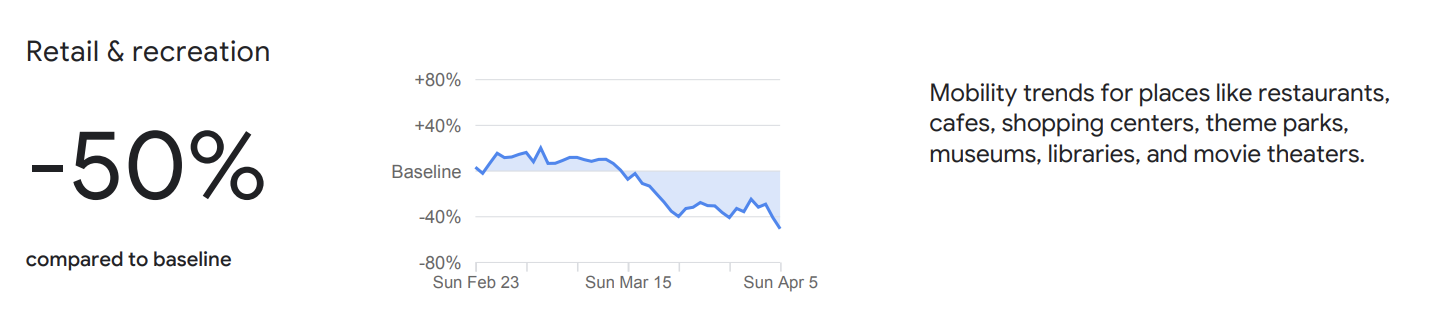

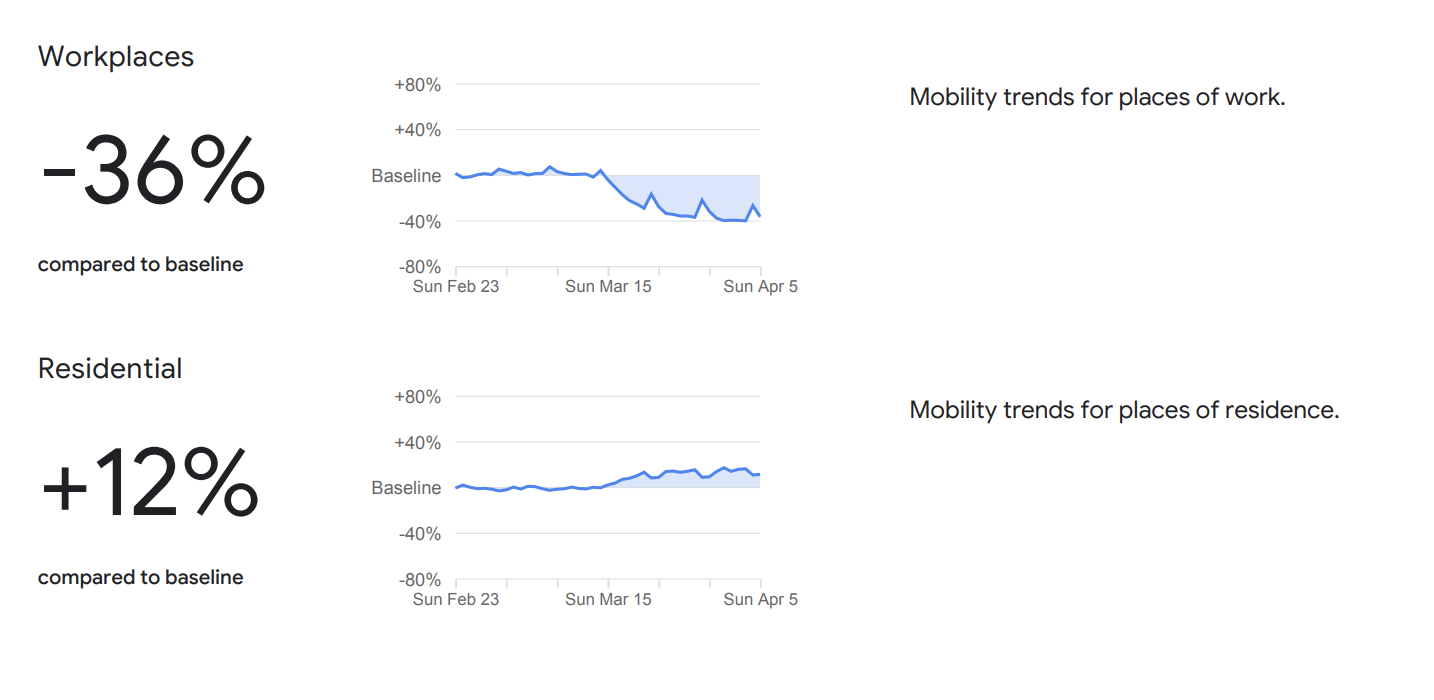

In [ ]:
columns = ['Retail_and_Recreation', 'Residential',
       'Workplaces', 'inf_rate_dec', 'inf_rate_inc']

columns, coefficients = run_variable_selection(growth_rate, mob2, columns, NFOLDS=3, RANDOM_STATE=42, N_REPEATS=30)
coefficients.sort_values(by = 'weight', ascending = False).head(10)

# **Estimate Statistical Significane for Selected Variables**

* Target: Relative Decrease in Growth Rate:
(['inf_rate_dec'] - ['inf_rate_inc']) / ['inf_rate_inc']

* Ordinary Least Squares without Constant (we assume we have all factors of mobility decrease)
* See output below (p-value less than 0.1 for all variables)

In [ ]:
result, X, Y = run_stat_significance(growth_rate, mob4, columns)
result.summary()

# **Show Variable-Target Correlations**
They are not THAT strong - we made quarantine for all areas at the same time :(

In [ ]:
show_correlations(X, Y)

# **Show Correlation between Decrease in Workplaces, Increase in Residential and Growth Rate Decrease**

* Growth Rate decrease is colored - dark values are better, so you can see: proportional exchange between areas pays off.
* In other words: you should go to Residential not in larger extent, than you go to work

In [ ]:
show_correlations_color_target_work(X, Y)

# **Show Correlation between Decrease in Retail and Recreation, Increase in Residential and Growth Rate Decrease**

* Growth Rate decrease is colored - dark values are better, so you can see: proportional exchange between areas pays off.
* In other words: you should go to Residential not in larger extent, than you go to Retail and Recreation 

In [ ]:
show_correlations_color_target_retail(X, Y)

# **Let's get more explanatory variables!**

# **Pre-filter Census Age and Population Variables by fixed PValue = 0.01**

In [ ]:
vars03 = get_dp03_vars(growth_rate, dp03)

# **Pre-filter Census Income and Ethnicity Variables by fixed PValue = 0.0005**

In [ ]:
vars05 = get_dp05_vars(growth_rate, dp05, pvalue = 0.01)

vars05 += ['density', 'Estimate_SEX_AND_AGE_Total_population', 'Square']
dp05 = pd.merge(dp05, state_square, left_on = 'Geographic_Area_Name', right_on = 'State', how = 'left')
dp05['Square'] = dp05['Square'].str.replace(',','').astype('float')
dp05['density'] = dp05['Estimate_SEX_AND_AGE_Total_population'] / dp05['Square']

# **Pre-filter Weather Min, Max, Median, Std Statistics by fixed PValue = 0.05**

In [ ]:
df_weather, vars07 = get_weather_vars(growth_rate, final_weather, pvalue = 0.01)

# **Calculate EpiRank values (like PageRank in Google but for Epidemics Networks)**

* Input: US Census Supply Chain Network Data with Origin - Destination connections
* Output: Measure of network value of particular state by Goods value, weight, distance delivered.

More about EpiRank: https://www.nature.com/articles/s41598-019-41719-8

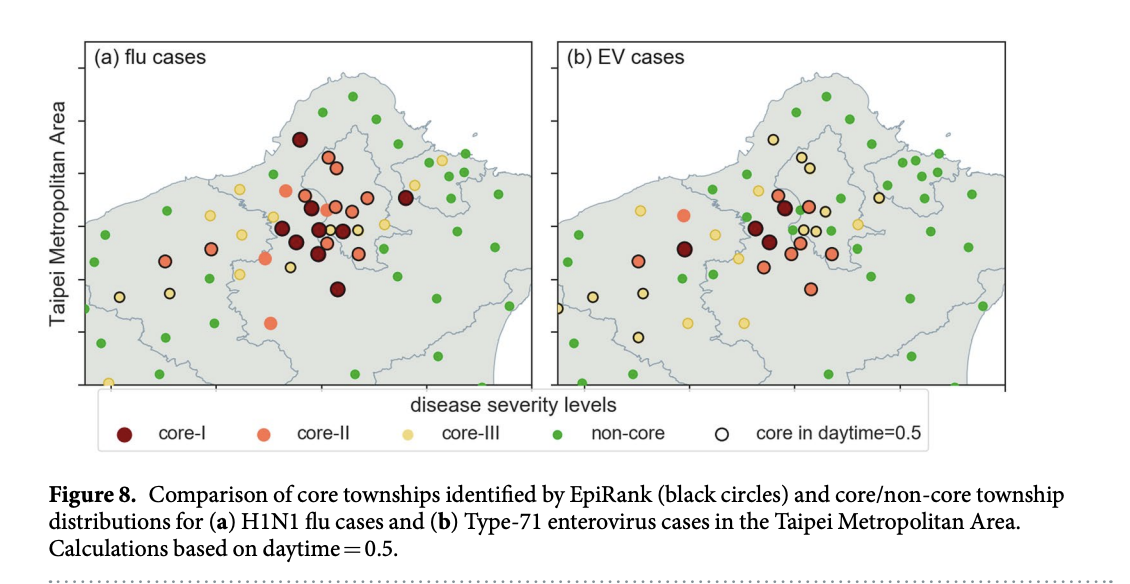

# **Pre-filter EpiRank Indicators by fixed PValue = 0.01**

We get significance for distance indicators - it means "value of abandoncy" is really useful with explaining current Growth Rate.

In [ ]:
sc_data = pd.read_csv('/kaggle/input/us-supply-chain-information-for-covid19/cfs-2012-pumf-csv/cfs_2012_pumf_csv.txt', sep=',')
sc_codes = pd.read_csv('/kaggle/input/us-supply-chain-information-for-covid19/state_code_to_name.csv', sep=',')

epi_data, vars09 = get_epirank_vars(growth_rate, sc_data, sc_codes)

# **The last chapter is dedicated to Wassily Leontief**
https://en.wikipedia.org/wiki/Wassily_Leontief 

Russian, born in Germany, worked in USA. Created Leontief Input-Output Analysis which allows to study inter-industry network effect in economics.
In the end, multiplication of effects could be modeled with single matrix NxN where N - number of industries. This matrix is called Leontief Inverse.


# **Which industries will rise and which industries will fall after crisis?**

We will do the following:
1. We take input-output tables structured by industry NAICS codes from US Bureau of Labour Statistics: https://www.bls.gov/emp/data/input-output-matrix.htm
2. We calculate Leotief Inverse according to the following calculation and naming conventions, found in ZIP above: https://drive.google.com/file/d/1G5pwk0QFm_dBuTNLJzkUVPsGAfebiX48/view?usp=sharing
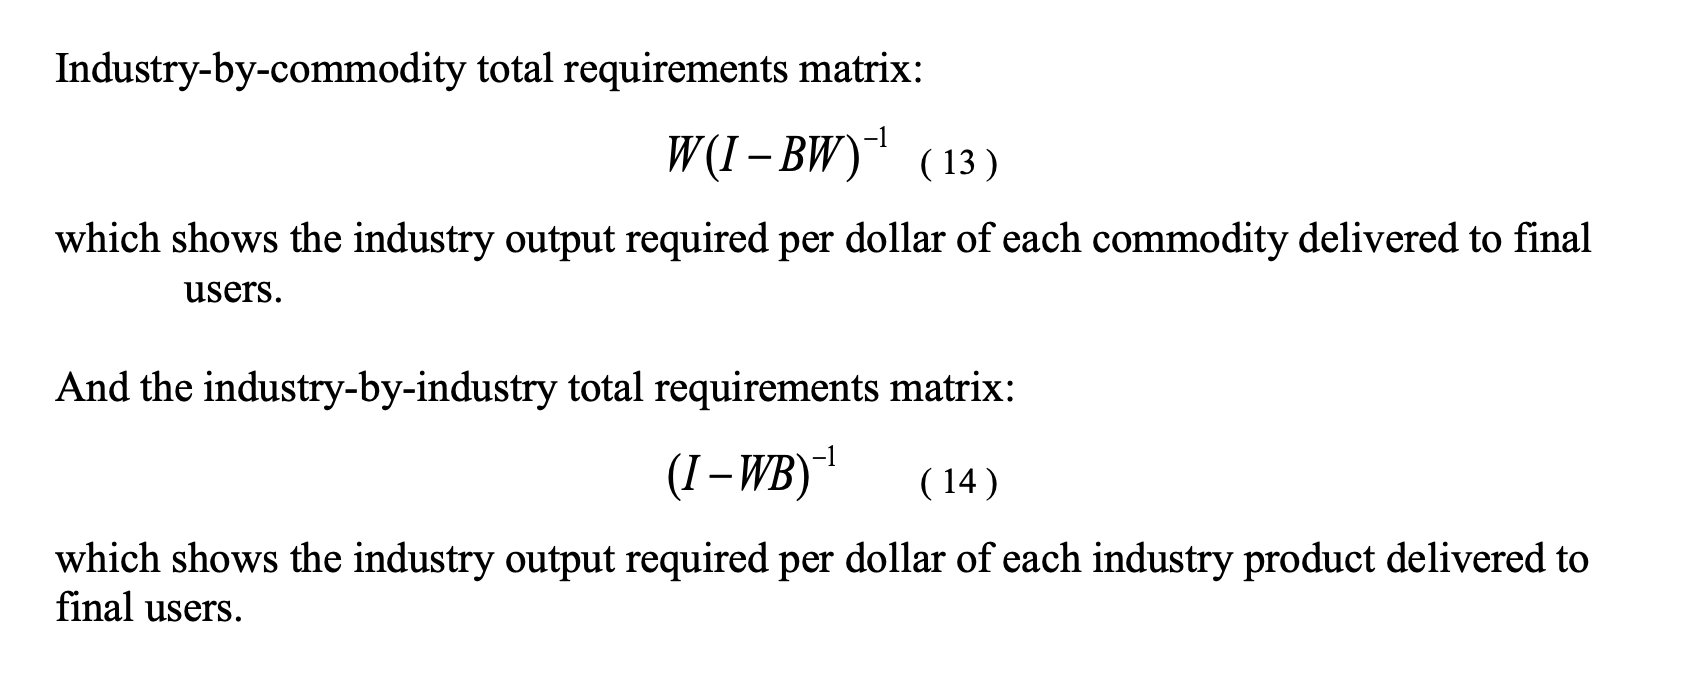

3. We load 2019-2020 Producer Price Index data from Federal Reserve Bank of St.Louis: https://fred.stlouisfed.org/ to evaluate current state for every particular industry. We calculate growth rate as simple linear regression slope based on one year of monthly data. 

4. We take current final demand values, mutiply it by projected yearly decrease and then multiplu it with Leontief Inverse to get network effects.

5. We can see which indsutries will rise and fall!

# **Prepare Initial Matrices and Show Industry Connections**

In [ ]:
path = '/kaggle/input/io-tables/'
filename = 'PROJECTED_USE_2028.csv'
proj_use_ci = pd.read_csv(path + filename, sep = ';').set_index('Sector')

filename = 'PROJECTED_MAKE_2028.csv'
proj_make_ic = pd.read_csv(path + filename, sep = ';').set_index('Sector')

filename = 'SectorPlan312.csv'
sec_plan_312 = pd.read_csv(path + filename, sep = ';')

i2i, c2c, g, W = calc_leontieff_inverse(proj_use_ci, proj_make_ic, sec_plan_312)
sec_plan_312.reset_index(inplace=True)
df = get_industry_by_num(i2i, sec_plan_312, N=48)

df.head(10)

# **Load Producer Price Index Data from Federal Reserve Bank API**
(including manual mapping of some NAICS codes)

In [ ]:
final_df = get_ppi_fred_data(sec_plan_312)

# **Calculate Linear Regression Slope for Every Industry based on 2019-2020 PPI Stats**

In [ ]:
industry_slope =  calc_industry_slope(final_df)
industry_slope.head(10)

# **Show Separated Effects for Particular Industry and Connected Industries**

In [ ]:
df, sec_plan_312_v2 = show_industry_effects(sec_plan_312, industry_slope, i2i)
df.head(10)

# **Let's see which industries will rise and fall!**
* Calculate Final Demand (see io_description.pdf)
* Final Demand Decrease with Regression Slope
* Multiply Decreased Final Demand by Leontief Inverse

In [ ]:
df = show_industry_network_effects(proj_use_ci, proj_make_ic, sec_plan_312_v2, c2c, g, W)
# df[df['value_dec'] > 0].sort_values(by='value_dec', ascending = False).head(15)
df.head(15)

# **Bottom Industries**

In [ ]:
df[~df.value_dec.isna()].iloc[:,1:].sort_values(by='industry_dec', ascending = True).head(30)

# **Top Industries**

In [ ]:
df.iloc[:,1:].sort_values(by='industry_dec', ascending = False).head(30)

# **Connect Industry Projected Performance to the Supply Chain Network **

* Based on NAICS code for ORIGIN_STATE
* We've assumed to have bigger NAICS code intersection

In [ ]:
df1 = pd.read_excel('/kaggle/input/us-supply-chain-information-for-covid19/cfs-2012-pum-file-users-guide-app-a-jun2015.xlsx', sheet_name = 'App A2', header = 1)
df2 = sec_plan_312_v2
df3 = pd.read_csv('/kaggle/input/mapping/Mapping_SC_NAICS_2017.csv', sep=';')

df5 = map_naics_to_supply_chain(df1,df2,df3)

In [ ]:
sc_est = get_supply_chain_industry_features(sc_data, sc_codes, df5)

# **Prepare Dataset for What-If Analysis**

In [ ]:
df, df1, df2, df3 = prepare_what_if_data(test_targ, mob, mob2, mob4, lock_dates, state_data)
df.head(10)

# **Build What-If Analysis Model**

In [ ]:
mdf, md = build_what_if_model()
print(mdf.summary())

# **Run Simulations**

In [ ]:
DAYS_FORECAST = 6
INCREASE_WORK_RECREATION = -0.05
INCREASE_RESIDENTIAL = -0.05
DATE_LAST_USED = 20200522
DATE_FORECAST = 20200528

test = run_simulation(test_targ, df3, mdf, md, DAYS_FORECAST, INCREASE_WORK_RECREATION, INCREASE_RESIDENTIAL)
test.sort_values(by='pred', ascending = False)

# **Train Final Explanatory Model**

Features included:
* Google Mobility (Retail and Recreation, Workplaces, Residential)
* Age and Population (PRE-FILTERED: Percent Commute to Work by Types by Age, Percent Population 65+)
* Income and Etnicity (PRE-FILTERED: 
* Weather Data (PRE-FILTERED: windspeed max + std, snowdepth max)
* EpiRank Indicators of Supply Chain "Abandonness" (PRE-FILTERED)
* Supply Chain State Industry Growth/Decrease Indicators (average effect across STATE industry codes)
* Do we have subway in our state? :)

We are able to beat the CV and OOF baseline with proper regularization and feature preparation!

In [ ]:
mob_cols = ['Retail_and_Recreation', 'Residential',
           'Workplaces', 'state']

state_static_diff = pd.DataFrame()
state_static_diff = test[['Group']]

coefficients, oof_preds_mod, all_data, X = train_explanatory_model(state_static_diff, mob4, dp03, dp05, df_weather, epi_data, mob_cols, vars03, vars05, vars07, vars09, ALPHA = 100)
coefficients.sort_values(by = 'weight', ascending = False).head(50)

# **Show Significant Variables**

In [ ]:
Y = all_data['inf_rate_dec']
selected_cols = ['density', 'epirank_dist_r']
X = all_data[selected_cols].fillna(0)
clf = sm.OLS(Y, X)
clf = clf.fit()
print(clf.summary())

# **Show Feature Importances**

(More Domain Knowledge could be incorporated into Selection)

In [ ]:
show_feature_importance(coefficients)

# **Show Interesting Rulesets**

In [ ]:
target = state_static_diff.reset_index()
all_data['Province/State'] = all_data['Province/State'].str.replace('of','Of')
X4 = pd.merge(all_data, target, left_on = 'Province/State', right_on = 'index')
        
draw_feature(['density', 'epirank_dist_r'], min_samples_leaf=10)
show_correlations_color_target(X4[['density', 'epirank_dist_r']], X4['Group'])

# **Show States for Ruleset**


In [ ]:
X4[(X4.density > 400) & (X4.epirank_dist_r < 0.02)]

# **Show States for Ruleset on Map**

Show on Map:

https://www.amcharts.com/visited_states/#US-AL,US-CT,US-DC,US-DE,US-FL,US-GA,US-IN,US-KY,US-MA,US-MD,US-NC,US-NJ,US-NY,US-OH,US-PA,US-RI,US-SC,US-VA,US-WV

Show with Humidity and Wind Direction: 

https://www.windy.com/-Humidity-rh?rh,40.835,-84.710,5

https://www.windy.com/?40.835,-84.710,5

# **Show Prediction about Most Risky States**

* Harmonic mean: Growth Rate Risk combined with ICU Occupancy Ratio Risk
* EpiRank Risk: Worst place - 1, best - 50. Rating of "abandonness" in supply chain network.

In [ ]:
X2 = show_risky_states(all_data, beds_data, test_data, oof_preds_mod, X, sc_est, beta=0.3)
X2

# **Find Nearest Neighbours to Average State for Experiment**

In [ ]:
df9 = find_median_states_for_experiment(X, test)
df9

# **Show Containment and Mitigation Measures**

In [ ]:
cont_mit_data